In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

!pip install scikit-tensor-py3
from sktensor import dtensor

import pandas as pd
import numpy as np

import time
import datetime
import copy
import os
import joblib
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 27.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 83.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for numpy: filename=numpy-1.16.6-cp39-cp39-linux_x86_64.whl size=9574790 sha256=21b67fc915b69e32fafe74ad5fecc461dbc5bae260fdfbabc1bcda255fa8999b
  Stored in directory: /root/.cache/pip/wheels/ce/72/38/377a1055ac9b575ebba22e507856aecdc37f9bf6372703e5f9
  Created wheel for scipy: filename=scipy-1.3.3-cp39-cp39-linux_x86_64.whl size=54852353 sha256=e9e5117e6dbee5e2a340e58951bfc613905f84361c24697cb87471c0c55a783f
  Stored in directory: /root/.

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device('cuda')

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Use GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Use GPU: Tesla T4


#  Helper Function

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Load Data

In [ ]:
# Read data

%%time

file_path_train = '/content/drive/MyDrive/MiniProject/[1109]TrainData_adjusted.csv'
file_path_test = '/content/drive/MyDrive/MiniProject/[1109]TestData_adjusted.csv'

cols = ['userId', 'gender', 'sport', 'calories',
        'Route_id', 'distance', 'distance_adjusted_sum']

train_df1 = pd.read_csv(file_path_train, usecols=cols)
test_df1 = pd.read_csv(file_path_test, usecols=cols)

train_df1.rename(columns={'distance': 'workout_distance',
                         'distance_adjusted_sum': 'total_distance'},
                inplace=True)

test_df1.rename(columns={'distance': 'workout_distance',
                        'distance_adjusted_sum': 'total_distance'},
               inplace=True)

print(train_df1.shape)
print(test_df1.shape)

display(train_df1.head(1))

(50253, 7)
(12578, 7)


,userId,gender,sport,calories,workout_distance,Route_id,total_distance
0,11889307,unknown,bike,530.0,46.04,0,46.04


CPU times: user 14.3 s, sys: 3.26 s, total: 17.5 s
Wall time: 28.4 s


In [ ]:
train_df=train_df1.copy()
test_df=test_df1.copy()
print(train_df.shape)
print(test_df.shape)
display(train_df.head(1))

(50253, 7)
(12578, 7)


,userId,gender,sport,calories,workout_distance,Route_id,total_distance
0,11889307,unknown,bike,530.0,46.04,0,46.04


In [ ]:
# Encode gender feature

conditions = [
    (train_df['gender'] == 'male'),
    (train_df['gender'] == 'female'),
    (train_df['gender'] == 'unknown')]

choices = [0, 1, 2]

train_df['genderId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['gender'] == 'male'),
    (test_df['gender'] == 'female'),
    (test_df['gender'] == 'unknown')]

test_df['genderId'] = np.select(conditions, choices, default=0)

In [ ]:
# Encode sport feature

conditions = [
    (train_df['sport'] == 'run'),
    (train_df['sport'] == 'bike'),
    (train_df['sport'] == 'mountain bike')]

choices = [0, 1, 2]

train_df['sportId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['sport'] == 'run'),
    (test_df['sport'] == 'bike'),
    (test_df['sport'] == 'mountain bike')]

test_df['sportId'] = np.select(conditions, choices, default=0)
display(train_df.head(1))

,userId,gender,sport,calories,workout_distance,Route_id,total_distance,genderId,sportId
0,11889307,unknown,bike,530.0,46.04,0,46.04,2,1


In [ ]:
cols_to_normalize=['calories','workout_distance','total_distance']
scaler=MinMaxScaler()

train_df[cols_to_normalize]=scaler.fit_transform(train_df[cols_to_normalize])

test_df[cols_to_normalize]=scaler.fit_transform(test_df[cols_to_normalize])
display(train_df.head())

,userId,gender,sport,calories,workout_distance,Route_id,total_distance,genderId,sportId
0,11889307,unknown,bike,0.078625,0.345642,0,0.308995,2,1
1,1912029,female,run,0.136886,0.075237,8,0.067260,1,0
2,4584909,male,run,0.285244,0.114624,12,0.102471,0,0
3,80101,male,run,0.125251,0.067774,10,0.060589,0,0
4,3987593,male,bike,0.201682,0.222248,1,0.198684,0,1


In [ ]:
# # Fit onehot encoder for categorical features

OneHot_enc = OneHotEncoder()
OneHot_enc.fit(pd.concat([train_df[['genderId', 'sportId']], 
                          test_df[['genderId', 'sportId']]]))

# # Save onehot encoder

file_path = '/content/drive/MyDrive/OneHotEncoder.m'

joblib.dump(OneHot_enc, file_path)

# Load onehot encoder for categorical features

dir = '/content/drive/MyDrive/OneHotEncoder.m'

OneHot_enc = joblib.load(dir)

In [ ]:
# Load user embedding and route embedding
# Note that we try different entity embedding sizes in our experiments in section 7


# # Entity Embedding size 2
user_dir = '/content/drive/MyDrive/MiniProject/Personalized_Intelligent_Fitness_Recommender-main/entity embedding/userEmbed_tensorD_2.m'
route_dir = '/content/drive/MyDrive/MiniProject/Personalized_Intelligent_Fitness_Recommender-main/entity embedding/routeEmbed_tensorD_2.m'

# # Entity Embedding size 11
# user_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/userEmbed_tensorD_11.m'
# route_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/routeEmbed_tensorD_11.m'

# Entity Embedding size 13
#user_dir = '/content/drive/MyDrive/MiniProject/Personalized_Intelligent_Fitness_Recommender-main/entity embedding/userEmbed_tensorD_13.m'
#route_dir = '/content/drive/MyDrive/MiniProject/Personalized_Intelligent_Fitness_Recommender-main/entity embedding/routeEmbed_tensorD_13.m'

user_embed_df = joblib.load(user_dir)
route_embed_df = joblib.load(route_dir)

In [ ]:
# find user embedding and route embedding for each row of data

%%time

# train data
train_userId_arr = train_df.userId.to_numpy()
train_userEmbed_arr = np.array([np.array(
    user_embed_df[user_embed_df.userId == userId].userEmbed.values[0]) for userId in train_userId_arr])

train_Route_id_arr = train_df.Route_id.to_numpy()
train_routeEmbed_arr = np.array([np.array(
    route_embed_df[route_embed_df.Route_id == Route_id].routeEmbed.values[0]) for Route_id in train_Route_id_arr])

# test data
test_userId_arr = test_df.userId.to_numpy()
test_userEmbed_arr = np.array([np.array(
    user_embed_df[user_embed_df.userId == userId].userEmbed.values[0]) for userId in test_userId_arr])

test_Route_id_arr = test_df.Route_id.to_numpy()
test_routeEmbed_arr = np.array([np.array(
    route_embed_df[route_embed_df.Route_id == Route_id].routeEmbed.values[0]) for Route_id in test_Route_id_arr])

CPU times: user 43.4 s, sys: 965 ms, total: 44.4 s
Wall time: 44.1 s


In [ ]:
# one hot encode gender and sport features

%%time

# train data
train_gender_sport_arr = train_df[['genderId', 'sportId']].to_numpy()
train_gender_sport_arr = OneHot_enc.transform(train_gender_sport_arr).toarray()

# test data
test_gender_sport_arr = test_df[['genderId', 'sportId']].to_numpy()
test_gender_sport_arr = OneHot_enc.transform(test_gender_sport_arr).toarray()

CPU times: user 12.2 ms, sys: 4.85 ms, total: 17 ms
Wall time: 24.3 ms


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [ ]:
# train_data_arr: calories (1), total_distance (1), user embedding (2/11/13), route embedding (2/11/13), gender onehot (3), sport onehot (3)

%%time

# train data
train_data_arr = np.hstack((train_df[['calories', 'total_distance']].to_numpy(
), train_userEmbed_arr, train_routeEmbed_arr, train_gender_sport_arr))
train_label_arr = train_df.workout_distance.to_numpy()

# test data
test_data_arr = np.hstack((test_df[['calories', 'total_distance']].to_numpy(
), test_userEmbed_arr, test_routeEmbed_arr, test_gender_sport_arr))
test_label_arr = test_df.workout_distance.to_numpy()

print('train_data_arr shape: ', train_data_arr.shape)
print('train_label_arr shape: ', train_label_arr.shape)
print('test_data_arr shape: ', test_data_arr.shape)
print('test_label_arr shape: ', test_label_arr.shape)

train_data_arr shape:  (50253, 12)
train_label_arr shape:  (50253,)
test_data_arr shape:  (12578, 12)
test_label_arr shape:  (12578,)
CPU times: user 8.02 ms, sys: 2.7 ms, total: 10.7 ms
Wall time: 15.4 ms


In [ ]:
# train validation split

train_data, val_data, train_label, val_label = train_test_split(
    train_data_arr, train_label_arr, test_size=0.2, shuffle=True, random_state=1021)

print('train data count: ', train_data.shape[0])
print('val data count: ', val_data.shape[0])
print('test data count: ', test_data_arr.shape[0])

train data count:  40202
val data count:  10051
test data count:  12578


In [ ]:
class DisReg_Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

	# return a data sample
    def __getitem__(self, idx): 

        data = self.X[idx]
        label = self.y[idx]
         
        return data, label

    def __len__(self):
        return len(self.X)

In [ ]:
ds_train = DisReg_Data(train_data, train_label)
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=32, 
                                       shuffle=True,
                                       drop_last=True)

ds_val = DisReg_Data(val_data, val_label)
dl_val = torch.utils.data.DataLoader(ds_val, 
                                     batch_size=32, 
                                     shuffle=True,
                                     drop_last=True)

ds_test = DisReg_Data(test_data_arr, test_label_arr)
dl_test = torch.utils.data.DataLoader(ds_test, 
                                     batch_size=32, 
                                     shuffle=True,
                                     drop_last=True)

In [ ]:
def save_model(filename, 
               best_model,
               best_epoch,
               best_loss_train,
               lowest_loss_val,
               epochs,
               latest_model,
               optimiser,
               total_losses_train,
               total_losses_val):

    DATA_PATH = "/content/drive/MyDrive/"+filename
    state = {
        'best_model_state_dict': best_model,
        'best_epoch': best_epoch,
        'best_loss_train': best_loss_train,
        'lowest_loss_val': lowest_loss_val,
        'epochs': epochs,
        'latest_model_state_dict': latest_model,
        'optimiser_state_dict': optimiser,
        'total_losses_train': total_losses_train,
        'total_losses_val': total_losses_val
    }
    torch.save(state, DATA_PATH)


def train_model(model,
                optimiser,
                criterion,
                num_epochs,
                dl_train,
                dl_val, 
                show_progress_epoch,
                save_model_epoch,
                save_model_name,
                continue_train = False, 
                previous_best_train_loss = 0,
                previous_lowest_val_loss = 0,
                best_model_state_dict = 0,
                previous_best_epoch = 0,
                previous_epochs = 0,
                previous_train_loss = 0,
                previous_val_loss = 0):

    checkpoint = time.time()

    # we have this parameter passed to the function to indicate if we continue training
    if continue_train:
        # if continue training, we load previous training progress
        epochs = previous_epochs
        total_losses_train = previous_train_loss
        total_losses_val = previous_val_loss
        num_epoch_from_previous_training = previous_epochs[-1]+1
        best_epoch = previous_best_epoch
        best_loss_train = previous_best_train_loss
        lowest_loss_val = previous_lowest_val_loss
        best_model_wts = copy.deepcopy(best_model_state_dict)

    else:
        # if not continue training, we create new variables to save training progress
        epochs = []
        total_losses_train = []
        total_losses_val = []
        num_epoch_from_previous_training = 1
        lowest_loss_val = 100000.


    # iterate over number of epochs

    for epoch in range(num_epoch_from_previous_training, num_epochs+1):

        check_epoch = time.time()

        # update epoch record
        epochs.append(epoch)

        # Training:
        # create empty list to save training loss for each epoch
        train_losses_epoch = []

        # iterate over mini-batches

        for train_data, train_label in dl_train:

            # convert to cuda if available
            train_data = train_data.float().to(device)
            train_label = train_label.float().to(device)


            # model prediction and back propagation
            model.train()

            optimiser.zero_grad()
            output = model(train_data)
            loss = criterion(output.squeeze(), train_label)
          
            loss.backward()
            optimiser.step()

            # store mini-batch loss
            train_losses_epoch.append(loss.item())

        # get average training loss for the epoch over mini-batches
        train_losses_epoch = np.average(train_losses_epoch)

        # add training loss of epoch to total training loss list
        total_losses_train.append(train_losses_epoch)

        # Validation:

        # create empty list to save val loss for each epoch
        val_losses_epoch = []

        for val_data, val_label in dl_val:

            # convert to cuda if available
            val_data = val_data.float().to(device)
            val_label = val_label.float().to(device)

            model.eval()

            with torch.no_grad():
                output = model(val_data)
                loss = criterion(output.squeeze(), val_label)

            val_losses_epoch.append(loss.item())

        # get average val loss for the epoch over mini-batches
        val_losses_epoch = np.average(val_losses_epoch)
        # add val loss of epoch to total val loss list
        total_losses_val.append(val_losses_epoch)

        elapsed_epoch = format_time(time.time() - check_epoch)

        # show training progress at pre-defined interval
        if epoch % show_progress_epoch == 0:
            print('Epoch: {} Elapsed {} | Train Loss: {:.4} | Val Loss: {:.4}'.format(
                epoch, elapsed_epoch, train_losses_epoch, val_losses_epoch))

        # save best model
        if val_losses_epoch < lowest_loss_val:
            lowest_loss_val = val_losses_epoch
            best_epoch = epoch
            best_loss_train = train_losses_epoch
            best_model = copy.deepcopy(model)


        # save model during training at pre-defined interval
        if epoch % save_model_epoch == 0:
            save_model(save_model_name,
                       best_model.state_dict(),
                       best_epoch,
                       best_loss_train,
                       lowest_loss_val,
                       epochs,
                       model.state_dict(),
                       optimiser.state_dict(),
                       total_losses_train,
                       total_losses_val)


    elapsed = format_time(time.time() - checkpoint)
    print('Training complete in: {}. Lowest validation loss occurred at epoch {}: {:.4}'.format(
                elapsed, best_epoch, lowest_loss_val))

In [ ]:
# Define function to load model

def load_model(filename, best_model, latest_model):

    DATA_PATH = "/content/drive/MyDrive/"+filename

    checkpoint = torch.load(DATA_PATH)

    best_model.load_state_dict(checkpoint['best_model_state_dict'])
    best_epoch = checkpoint['best_epoch']
    best_loss_train = checkpoint['best_loss_train']
    lowest_loss_val = checkpoint['lowest_loss_val']
    epochs = checkpoint['epochs']
    latest_model.load_state_dict(checkpoint['latest_model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
    total_losses_train = checkpoint['total_losses_train']
    total_losses_val = checkpoint['total_losses_val']

    return best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, \
        latest_model, optimiser, total_losses_train, total_losses_val

In [ ]:
# Define model

class DisReg_MLP_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, p):
        super(DisReg_MLP_2Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)

        return output

In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1

In [ ]:
# Random Search

np.random.seed(32)

LEARNING_RATE = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
HIDDEN_DIM = np.array([4, 8, 16, 32, 64])
WEIGHT_DECAY = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
DROP_OUT = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

para_result = []

N_TRIAL = 50

for trial in range(1, N_TRIAL+1):
    lr = np.random.choice(LEARNING_RATE)
    hd = np.random.choice(HIDDEN_DIM)
    wd = np.random.choice(WEIGHT_DECAY)
    dp = np.random.choice(DROP_OUT)

    DisReg_MLP_tmp = DisReg_MLP_2Layer(
        INPUT_DIM, hd, dp).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=lr, weight_decay=wd)
    
    criterion = torch.nn.MSELoss()

    print('Trial# ', trial)

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME, 
        DisReg_MLP_tmp, 
        DisReg_MLP_tmp)

    print(
        'Learning rate: {}, Hidden dim: {}, Weight decay: {}, Drop out: {}, '\
        'Train loss: {:.4f}, Val loss: {:.4f}'.format(
            lr, hd, wd, dp, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([lr, hd, wd, dp, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Learning_rate',
             'Hidden_dim',
             'Weight_decay',
             'Drop_out',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/section_7_1_2_para_result.m'
joblib.dump(para_result, file_path)

Trial#  1
Training complete in: 0:01:54. Lowest validation loss occurred at epoch 47: 0.03393
Learning rate: 0.0001, Hidden dim: 64, Weight decay: 0.1, Drop out: 0.3, Train loss: 0.0357, Val loss: 0.0339

Trial#  2
Training complete in: 0:01:50. Lowest validation loss occurred at epoch 50: 0.008699
Learning rate: 1e-05, Hidden dim: 8, Weight decay: 0.0001, Drop out: 0.5, Train loss: 0.0131, Val loss: 0.0087

Trial#  3
Training complete in: 0:01:50. Lowest validation loss occurred at epoch 34: 0.0003094
Learning rate: 0.001, Hidden dim: 8, Weight decay: 1e-05, Drop out: 0.3, Train loss: 0.0018, Val loss: 0.0003

Trial#  4
Training complete in: 0:01:51. Lowest validation loss occurred at epoch 18: 0.008973
Learning rate: 0.01, Hidden dim: 32, Weight decay: 0.01, Drop out: 0.2, Train loss: 0.0110, Val loss: 0.0090

Trial#  5
Training complete in: 0:01:51. Lowest validation loss occurred at epoch 38: 0.002189
Learning rate: 0.0001, Hidden dim: 4, Weight decay: 0.001, Drop out: 0.2, Train l

['/content/drive/MyDrive/section_7_1_2_para_result.m']

In [ ]:
file_path = '/content/drive/MyDrive/section_7_1_2_para_result.m'

para_result = joblib.load(file_path)

In [ ]:
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Learning_rate,Hidden_dim,Weight_decay,Drop_out,Best_epoch,Train_loss,Val_loss
8,0.001,64,0.000001,0.2,12,0.000329,0.000163


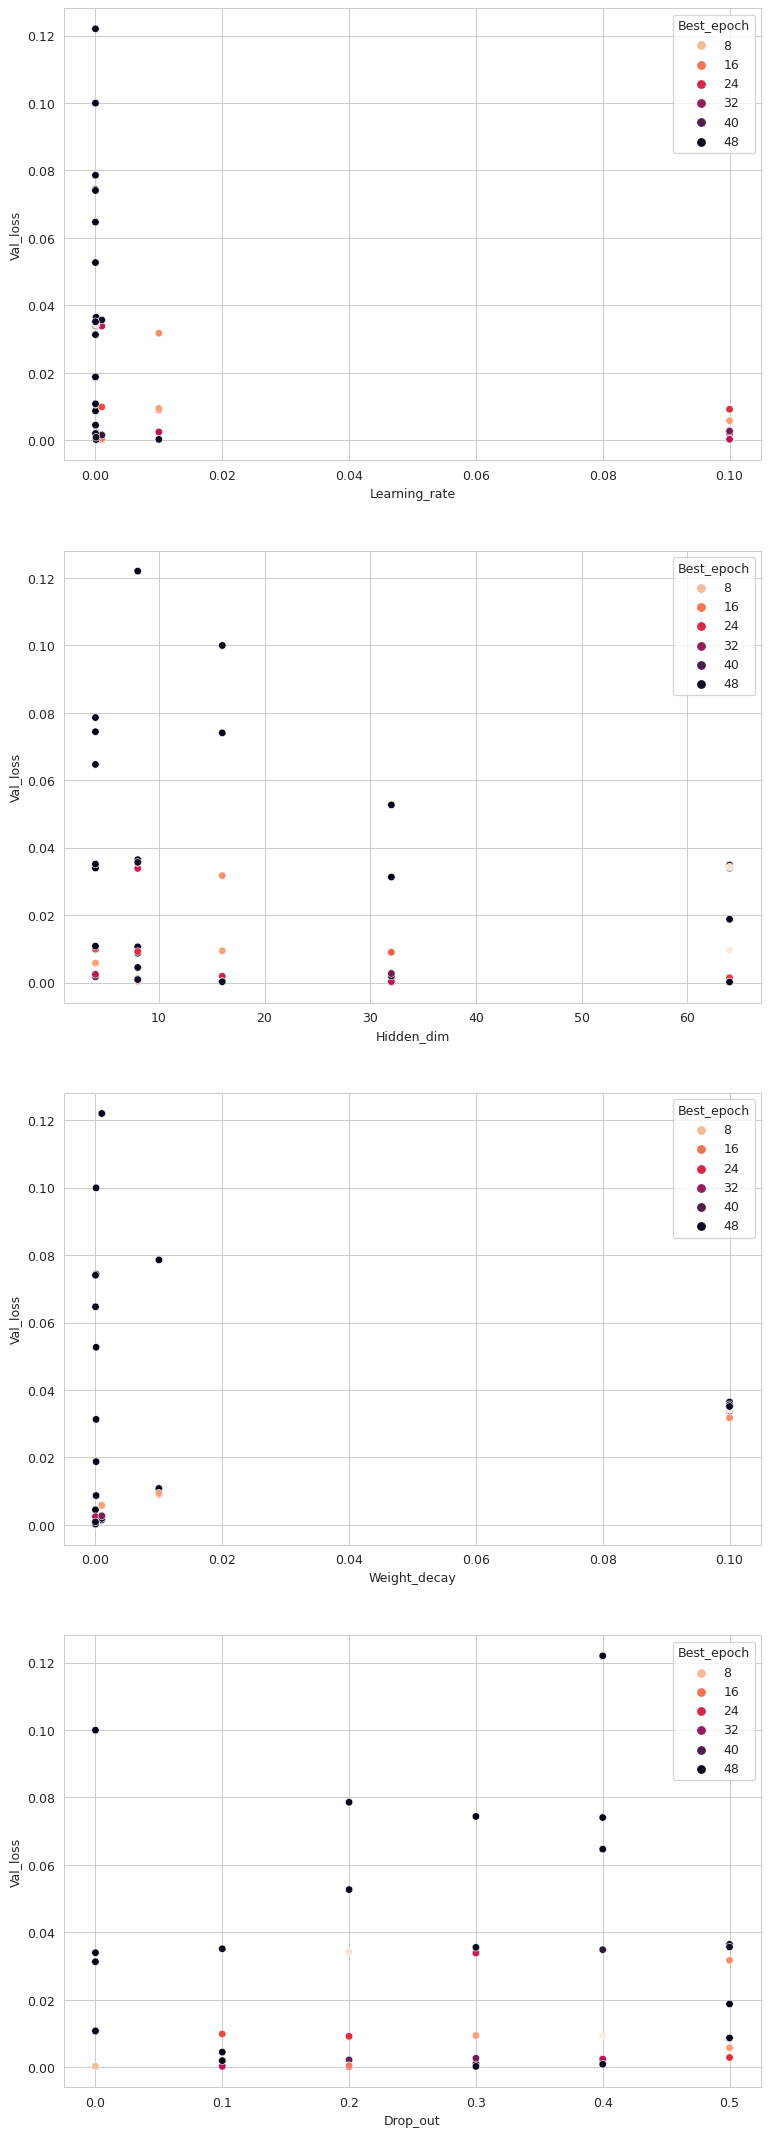

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 30), dpi=90)

for idx, feat in enumerate(['Learning_rate', 'Hidden_dim', 'Weight_decay', 'Drop_out']):
    sns.scatterplot(x=feat,
                    y='Val_loss',
                    data=para_result,
                    palette=sns.color_palette('rocket_r', as_cmap=True),
                    hue='Best_epoch',
                    ax=axes[idx])

# 7.1.5


In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1
LEARNING_RATE = 1e-3
HIDDEN_DIM = 64
DROP_OUT = 0.2

In [ ]:
WEIGHT_DECAY = np.array([1e-5, 1e-6, 1e-7, 1e-8])

para_result = []

for wd in WEIGHT_DECAY:

    DisReg_MLP_tmp = DisReg_MLP_2Layer(
        INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=LEARNING_RATE, weight_decay=wd)
    
    criterion = torch.nn.MSELoss()

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME, 
        DisReg_MLP_tmp, 
        DisReg_MLP_tmp)

    print(
        'Weight decay: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
            wd, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([wd, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Weight_decay',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/section_7_1_5_para_result.m'
joblib.dump(para_result, file_path)

Training complete in: 0:01:59. Lowest validation loss occurred at epoch 17: 0.0001961
Weight decay: 1e-05, Train loss: 0.0003390, Val loss: 0.0001961

Training complete in: 0:01:55. Lowest validation loss occurred at epoch 27: 0.000165
Weight decay: 1e-06, Train loss: 0.0003209, Val loss: 0.0001650

Training complete in: 0:01:54. Lowest validation loss occurred at epoch 43: 0.0001597
Weight decay: 1e-07, Train loss: 0.0002977, Val loss: 0.0001597

Training complete in: 0:01:53. Lowest validation loss occurred at epoch 29: 0.0001617
Weight decay: 1e-08, Train loss: 0.0003144, Val loss: 0.0001617



['/content/drive/MyDrive/section_7_1_5_para_result.m']

# 7.1.6

In [ ]:
file_path = '/content/drive/MyDrive/section_7_1_5_para_result.m'

para_result = joblib.load(file_path)

display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Weight_decay,Best_epoch,Train_loss,Val_loss
2,1.000000e-07,43,0.000298,0.00016


In [ ]:
class DisReg_MLP_3Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, p):
        super(DisReg_MLP_3Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        self.act_3 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)
        self.drop_2 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)
        output = self.drop_2(output)

        output = self.fc3(output)
        output = self.act_3(output)

        return output

In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1

In [ ]:
# Random Search

np.random.seed(32)

LEARNING_RATE = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
HIDDEN_DIM_1 = np.array([8, 16, 32, 64])
WEIGHT_DECAY = np.array([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
DROP_OUT = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

para_result = []

N_TRIAL = 50

for trial in range(1, N_TRIAL+1):
    lr = np.random.choice(LEARNING_RATE)
    hd_1 = np.random.choice(HIDDEN_DIM_1)
    hd_2 = int(0.5*hd_1)
    wd = np.random.choice(WEIGHT_DECAY)
    dp = np.random.choice(DROP_OUT)

    DisReg_MLP_tmp = DisReg_MLP_3Layer(
        INPUT_DIM, hd_1, hd_2, dp).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=lr, weight_decay=wd)
    
    criterion = torch.nn.MSELoss()

    print('Trial# ', trial)

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME, 
        DisReg_MLP_tmp, 
        DisReg_MLP_tmp)

    print(
        'Learning rate: {}, Hidden dim 1: {}, Hidden dim 2: {}, Weight decay: {},'\
        'Drop out: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
            lr, hd_1, hd_2, wd, dp, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([lr, hd_1, hd_2, wd, dp, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Learning_rate',
             'Hidden_dim_1',
             'Hidden_dim_2',
             'Weight_decay',
             'Drop_out',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/section_7_2_2_para_result.m'
joblib.dump(para_result, file_path)

Trial#  1
Training complete in: 0:02:04. Lowest validation loss occurred at epoch 50: 0.0001788
Learning rate: 0.0001, Hidden dim 1: 16, Hidden dim 2: 8, Weight decay: 1e-07,Drop out: 0.0, Train loss: 0.0001911, Val loss: 0.0001788

Trial#  2
Training complete in: 0:02:08. Lowest validation loss occurred at epoch 49: 0.001227
Learning rate: 0.0001, Hidden dim 1: 8, Hidden dim 2: 4, Weight decay: 0.0001,Drop out: 0.3, Train loss: 0.0043046, Val loss: 0.0012273

Trial#  3
Training complete in: 0:02:08. Lowest validation loss occurred at epoch 50: 0.04954
Learning rate: 1e-06, Hidden dim 1: 32, Hidden dim 2: 16, Weight decay: 0.0001,Drop out: 0.4, Train loss: 0.0523344, Val loss: 0.0495400

Trial#  4
Training complete in: 0:02:08. Lowest validation loss occurred at epoch 48: 0.0002016
Learning rate: 0.0001, Hidden dim 1: 16, Hidden dim 2: 8, Weight decay: 1e-06,Drop out: 0.1, Train loss: 0.0009368, Val loss: 0.0002016

Trial#  5
Training complete in: 0:02:08. Lowest validation loss occurr

['/content/drive/MyDrive/section_7_2_2_para_result.m']

In [ ]:
file_path = '/content/drive/MyDrive/section_7_2_2_para_result.m'

para_result = joblib.load(file_path)

In [ ]:
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Learning_rate,Hidden_dim_1,Hidden_dim_2,Weight_decay,Drop_out,Best_epoch,Train_loss,Val_loss
12,0.001,64,32,1.000000e-08,0.2,43,0.000541,0.000161


In [8]:
fig, axes = plt.subplots(5, 1, figsize=(10, 30), dpi=90)

for idx, feat in enumerate(['Learning_rate', 'Hidden_dim_1', 'Hidden_dim_2', 'Weight_decay', 'Drop_out']):
    sns.scatterplot(x=feat,
                    y='Val_loss',
                    data=para_result,
                    palette=sns.color_palette('rocket_r', as_cmap=True),
                    hue='Best_epoch',
                    ax=axes[idx])

NameError: ignored

In [7]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1
LEARNING_RATE = 1e-3
HIDDEN_DIM_1 = 64
DROP_OUT = 0.2

In [6]:
WEIGHT_DECAY = np.array([1e-7, 1e-8, 1e-9, 1e-10])
HIDDEN_DIM_2 = np.array([8, 16, 32, 64])

para_result = []

for wd in WEIGHT_DECAY:
    for hd_2 in HIDDEN_DIM_2:

        DisReg_MLP_tmp = DisReg_MLP_3Layer(
            INPUT_DIM, HIDDEN_DIM_1, hd_2, DROP_OUT).to(device)

        optimiser = optim.Adam(
            DisReg_MLP_tmp.parameters(),
            lr=LEARNING_RATE, weight_decay=wd)
        
        criterion = torch.nn.MSELoss()

        train_model(DisReg_MLP_tmp,
                optimiser,
                criterion,
                N_EPOCHS,
                dl_train,
                dl_val, 
                SHOW_PROGRESS_EPOCH,
                SAVE_MODEL_EPOCH,
                SAVE_MODEL_NAME,
                continue_train = False, 
                previous_best_train_loss = 0,
                previous_lowest_val_loss = 0,
                best_model_state_dict = 0,
                previous_best_epoch = 0,
                previous_epochs = 0,
                previous_train_loss = 0,
                previous_val_loss = 0)


        _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
        _, _, _ = load_model(
            SAVE_MODEL_NAME, 
            DisReg_MLP_tmp, 
            DisReg_MLP_tmp)

        print(
            'Weight decay: {}, Hidden dim 2: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
                wd, hd_2, best_loss_train, lowest_loss_val)
            )
        print('')

        para_result.append([wd, hd_2, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Weight_decay',
             'hidden_dim_2',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/scetion_7_2_5_para_result.m'
joblib.dump(para_result, file_path)

NameError: ignored

In [ ]:
file_path = '/content/drive/MyDrive/scetion_7_2_5_para_result.m'

para_result = joblib.load(file_path)

# show result with lowest validation loss
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Weight_decay,hidden_dim_2,Best_epoch,Train_loss,Val_loss
3,1.000000e-07,64,12,683.389576,675.837767
